In [15]:
%matplotlib inline
import os
import glob

import cv2
from osgeo import gdal
from pyproj import Proj, transform

import seaborn as sns
sns.set_style('white')
import skimage
import skimage.exposure

from pprint import pprint
import numpy as np
import pandas as pd
from planet import api
import matplotlib.colors
import matplotlib.pyplot as plt
from pysurvey.plot import setup_sns as setup, dateticks
plt.rc('axes.formatter', useoffset=False)


from datetime import datetime
from dateutil import parser
from matplotlib.dates import date2num, num2date

In [2]:
inproj = Proj(init='EPSG:3857')
outproj = Proj(init='epsg:4326')

def pixel2coord(ds, col, row):
    """Returns global coordinates to pixel center using base-0 raster index"""
    c, a, b, f, d, e = ds.GetGeoTransform()
    xp = a * col + b * row + a * 0.5 + b * 0.5 + c
    yp = d * col + e * row + d * 0.5 + e * 0.5 + f
#     return(xp, yp)
    return transform(inproj,outproj,xp,yp)

# filename = ds.GetDescription()
# print pixel2coord(ds, 0,0)
# !gdalinfo $filename

In [4]:
client = api.Client()
def get_scenes(point):
    loc = {
        'type':'Point', 
        'coordinates': point,
    }
#     scene_type = 'ortho'
    scene_type = 'landsat'
    filters = {
        'sat.off_nadir.leq': 39,
        'image_statistics.gsd.gte': 1,
        'image_statistics.gsd.lte': 18.7,
    #     'image_statistics_image_quality.gte':'target',
        'cloud_cover.estimated.gte': 0,
        'cloud_cover.estimated.lte': 10,
#         'published.gte':"2013-09-01T00:00:00.000Z",
        'acquired.gte':"2015-01-01T00:00:00.000Z",
    }
    scenes = client.get_scenes_list(scene_type=scene_type, 
                                    intersects=loc, 
                                    filters=filters, 
                                    )
    return scenes.get()

def get_all_scenes(points):
    
    for i, point in enumerate(points):
        key = tuple(point)
        if key in CACHE:
            continue
        CACHE[key] = get_scenes(key)
        if i%10 == 0:
            print i, len(CACHE)
#             break
# get_all_scenes(points)

# tmp = {str(k):v for k,v in CACHE.iteritems()}
# json.dump(tmp,
#           open('/Users/ajmendez/tmp/world/california/ortho_points.json','w'),
#           indent=2)

# tmp = {str(k):v for k,v in CACHE.iteritems()}
# json.dump(tmp,
#           open('/Users/ajmendez/tmp/world/california/landsat_points.json','w'),
#           indent=2)

In [6]:
point = (30.1503679, -81.6515311)
scenes = get_scenes(point)

In [29]:
# scenes

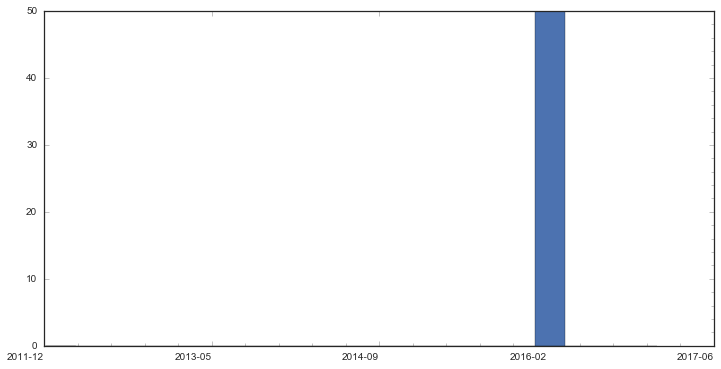

In [22]:
vmin = date2num(datetime(2012,1,1))
vmax = date2num(datetime(2017,1,1))

ndates = []
setup(figsize=(12,6))
for item in scenes['features']:
    item['properties']['ndate'] = date2num(parser.parse(item['properties']['acquired']))
    ndates.append(item['properties']['ndate'])
_ = plt.hist(ndates, np.linspace(vmin, vmax, 21))
dateticks('%Y-%m', rotation=0)

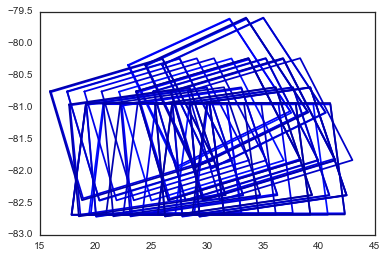

In [24]:
vmin = date2num(datetime(2016,1,1))
vmax = date2num(datetime(2017,1,1))
norm = matplotlib.colors.Normalize(vmin, vmax)

for item in scenes['features']:
    geo = item['geometry']['coordinates']
    
    x,y = zip(*geo[0])
    plt.plot(x,y, color=plt.cm.jet(norm(item['properties']['ndate'])))

In [27]:
scene_id = 'LC81071222016045LGN00'
outdir = '/Users/ajmendez/tmp/world/jacksonville/landsat/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
callback = api.write_to_file(outdir)

bodies = client.fetch_scene_geotiffs([scene_id], 
                                     scene_type='landsat', 
                                     product='band_8',
                                     callback=callback)
for b in bodies:
    b.await()

# USGS

In [32]:
import usgs.api

In [34]:
dataset = 'LANDSAT_7'
tmp = usgs.api.search(dataset='LANDSAT_7', node='EE',
                      lat=30.1503679, 
                      lng=-81.6515311)
tmp

<?xml version="1.0" encoding="UTF-8"?>
<SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/"><SOAP-ENV:Body><SOAP-ENV:Fault><faultcode>SEARCH_ERROR</faultcode><faultstring>Could not complete search request: API Key Required</faultstring></SOAP-ENV:Fault></SOAP-ENV:Body></SOAP-ENV:Envelope>



USGSError: SEARCH_ERROR: Could not complete search request: API Key Required

In [38]:
import os
import tempfile
from gbdxtools import Interface

gbdx = Interface()

multi_idahoID = '98ce43c5-b4a8-45aa-8597-ae7017ecefb2'
pan_idahoID = '5e47dfec-4685-476a-94ec-8589e06df349'

temp_path = '/Users/ajmendez/tmp/world/idaho/'
os.makedirs(temp_path)

result = gbdx.idaho.get_idaho_chip(bucket_name='idaho-images',
                                   idaho_id=multi_idahoID,
                                   center_lat=48.8611,
                                   center_lon=2.3358,
                                   pan_id=pan_idahoID,
                                   output_folder=temp_path)

print("IDAHO chip: {}".format(os.path.join(temp_path,multi_idahoID+'.tif')))


Exception: Please create a GBDX credential file at ~/.gbdx-config with these contents:
[gbdx]
auth_url = https://geobigdata.io/auth/v1/oauth/token/
client_id = your_client_id
client_secret = your_client_secret
user_name = your_user_name
user_password = your_password